# A Roundabout Discussion of *Dropout as a Bayesian Approximation* by Gal and Ghahramani

### (With asides into Bayes vs. Frequentism, Gaussian Processes, and Variational Inference)

## 1. Dropout Definitions
Dropout is a randomized procedure that randomly drops nodes at a given hidden layer in a neural network.  One way to write this is as
$$
\mathbf{x}_{l+1} = \sigma ( (\mathbf{x}_l\circ \mathbf{z}_l) W_{l+1} + \mathbf{b}_{l+1})
$$
$$
z_{i,l} \sim \mathrm{Bernoulli}(p_l)
$$
Alternatively, one could randomly zero the rows of $W_{l+1}$ according to a Bernoulli distribution, create a diagonal matrix with entries given by $z_{i,l}$...  There are lots of ways to write this idea.  For this paper, it will be useful to take the perspective that the weight matrices are the random variables:
$$
\mathbf{x}_{l+1} = \sigma (W_{l+1} \mathbf{x} + \mathbf{b}_{l+1})
$$
$$
W_{l} = M_l \cdot \mathrm{diag}(\mathbf{z}_l)
$$

Usually a neural network is a deterministic function.  However, now because of the presence of stochastic $\mathbf{z}_l$ (or $W_l$, if you prefer), the network becomes a random function, with the potential for its outputs $\hat{\mathbf{y}}$ to be *different* for the same input.  Of course, we saw that one common approach is to *only* use this stochasticity at training time, and then fix $\mathbf{z}_l$ to its expected value at test time.  However, we could retain that randomness by simply drawing new values of stochastic $\mathbf{z}_l$ every time we run the model forward.  As such, we would obtain *samples* from our neural network, which is now a *random function*. 


In [26]:
import numpy as np
np.random.seed(0)
def bernoulli(n,p):
    #p here is dropout probability
    u = np.random.rand(n)
    return (u>p).astype('float')

M = np.random.randn(4,3)
z = np.diag(bernoulli(3,0.2))
W = M @ z
print(W)
# If we multiply this matrix by an input feature x (of size 3), then 
# the third entry in x will be zeroed out.  

[[ 1.76405235  0.40015721  0.        ]
 [ 2.2408932   1.86755799  0.        ]
 [ 0.95008842 -0.15135721  0.        ]
 [ 0.4105985   0.14404357  0.        ]]


## 2. The Meaning of Uncertainty

There are several things that can be done with such samples.  As we learned in our discussion of Srivastava (2014), one application is to draw some number of samples (i.e. run the network, say 10 times) and then average the result in order to get a prediction.  There is some evidence to suggest that this produces better results than setting $\mathbf{z}_l$ to its expected value.  
- Why might this be?  
- What is the disadvantage of this method?  A clear disadvantage is that the network has to be run many times to produce the samples!  (Although only trained once).  

Its worth noting that once one has a sample from a random function, computing measures of central tendency are not the only thing that one can compute.  The primary example of this has been the (heretofore) somewhat *ad hoc* approach of computing not only the sample mean, *but also the sample variance or standard deviation*, and interpreting the latter as some kind of uncertainty, the primary idea being that for predictions that are uncertain, the sample variance should be large, and for predictions that are certain, the variance should be small (this applies to both regression problems and classification problems: the softmax probabilities should not be interpreted as a measure of uncertainty).

This idea has had some empirical success (Where?).  However, it also raises the question, *just what is uncertainty*?  

**In the frequentist case:** Establish a *confidence level* (often 95\%).  A confidence interval then says: if I compute an upper and lower bound on a prediction many (read infinitely many) times, in 95\% of cases, the true value of the prediction will lie between those bounds.  

**In the Bayesian case:** Establish a *credible level* (often 95\%).  A credible interval then says: there is a 95\% chance that the true value of the prediction lies within those bounds.  This is typically computed by taking quantiles of a prior or posterior probability distribution.  

The key difference here is in describing a prediction's value with a probability distribution (the Bayesian credible interval is trivially obtained from this distribution).  In the frequentist worldview, the prediction is fixed: it's just a number, while the data that it generates is random.  After the data is generated, there is no more randomness, and so there is no more probability to be discussed aside from the probabilities that would occur in association with generating additional data (hence why the definition of a confidence interval is couched in terms of *what would happen if I observed an infinite amount of data*).  In the Bayesian worldview, the data is fixed: Once it's observed, it represents all there (currently) is to know about the world.  We have to use that knowledge to constrain our inadequate knowledge about the state the world, which is quantified as a probability distribution.

So, **the question that differentiates the two ideas is: does it make sense to put a probability on a prediction (or hypothesis)?**  Can an assertion be true with 65\% probability?  If yes, then we're talking Bayes; if no, then frequentism.  It becomes clear then to see why Bayes theorem gives its name to the Bayesian school of thought:
$$
P(H|d) \propto P(d|H) P(H).
$$
If $H$ is a hypothesis, then Bayes theorem is explicitly used to write down its probability distribution (the only coherent definition, by the dutch book theorem), something that is explicitly disallowed under the frequentist definition.  

### 2a. Frequentist prediction and uncertainty
It's interesting to think about the concrete implications of this distinction in the context of Machine Learning.  Let's say that we have a neural network, we are interested in using it to make predictions, and we would like those predictions to come with one of the estimates of uncertainty described above.  Let's imagine that our problem is one of regression, for simplicity's sake.  In the frequentist context, we would have a two step procedure: first, we would assume that 
$$
\hat{y}^* = \mathrm{NN}_\omega(\mathbf{x}^*),
$$
where $\hat{y}^*$ is a prediction, $\mathbf{x}$ is a set of associated features, and $\mathrm{NN}_\omega$ is a neural network parameterized with weights and biases $\omega=\{W_1,\ldots,W_L\}$.  This is the entirety of the prediction step, but this model has parameters that are initially unknown.    

We now need to make an estimate for the values of the weights and biases in the neural network.  This is done via maximum likelihood estimation: assuming that we have $N$ observations $y_{obs,i},\; i\in 1\ldots N$, we would seek to find the point estimates of $\omega$ that maximize the (log-)likelihood of those data:
$$
\omega^* = \mathrm{argmax}_\omega \sum_{i=1}^N \log P(y_{obs,i}|\omega,\mathbf{x}_i), 
$$
where $\omega^*$ are the parameters that provide the "best fit" to the data, and $P(y_{obs,i}|\omega,\mathbf{x}_i)$ is the likelihood.  For regression problems, this would most often be *assumed* to be a normal distribution with mean given by the neural network and variance given by some assumed measurement noise with variance $\sigma^2$
$$
P(y_{obs,i}|\omega,\mathbf{x}_i) = \frac{1}{\sigma\sqrt{2\pi}} \mathrm{exp}\left[ -\frac{1}{2}\frac{(y_{obs,i} - \mathrm{NN}_\omega(x_i))^2}{\sigma^2} \right],
$$
the logarithm of which yields the familiar sum-squared-error that is minimized via, perhaps, gradient descent.  Of course this doesn't provide uncertainty, and so (because we're taking the frequentist approach) we still need to develop confidence intervals.  Concretely, a confidence interval is constructed such that if we performed the above fitting procedure an infinite number of times and used it to predict a given $y_i$ from its associated $x_i$, in 95% of the resulting instances the true value of $y_i$ would lie inside the confidence interval.  

There is a practical problem here: we have neither infinite time nor infinite data.  In certain simple cases (such as linear regression), there are analytical solutions for what the confidence intervals ought to be.  For complex models like neural nets there is no such analytical solutions and numerical methods for estimating confidence intervals have to be employed.  The most notable of these is the bootstrap, the details of which are beyond the scope of this discussion, but the gist of which is to randomly sample *with replacement* from the existing dataset, and to assume that the resulting *bootstrap sample* is a good approximation to the random dataset that would have been generated by collecting more data.  (See below for a simple example of bootstrapping).  It's worth noting that despite its simplicity, this often works really well.  It's also worth noting that this procedure is equally interpretable as "Bayesian."

### 2b. Bayesian prediction and uncertainty
The Bayesian conception of uncertainty is somewhat simpler to formulate.  If we allow ourselves the freedom to consider a probability distribution over predictions, then what we need is
$$
P(y^*|\mathbf{x}^*,\mathbf{X},\mathbf{Y}),
$$
which is the so-called posterior predictive distribution, or the distribution over predictions given feature values *and* some additional relevant training data $\mathbf{X},\mathbf{Y}$.  Some models can work with this formulation directly (for example Gaussian processes, see below), but it's oftentimes more convenient to write down
\begin{align}
P(y^*|\mathbf{x}^*,\mathbf{X},\mathbf{Y}) &= \int P(y^*,\omega|\mathbf{x}^*,\mathbf{X},\mathbf{Y})  \mathrm{d} \omega \\
&= \int P(y^*|\mathbf{x}^*,\omega) P(\omega|\mathbf{X},\mathbf{Y}) \mathrm{d} \omega,
\end{align}
where we've made a structural assumption that a prediction is independent of the training data once we have an intermediate trained model.  Concretely, the first term in the integrand (on the second line) is telling us the distribution over the prediction if we assume a fixed value for the neural network's parameters $\omega$.  The second term is, in turn, telling us the *distribution over the neural network's parameters given the training data*.  This is where there's a substantial departure from the frequentist method: in that context, a point estimate of the NN's parameters was determined using maximum likelihood estimation, but here we allow for them to be defined with a probability distribution.  However, when making a prediction, we aren't really interested in the distribution of those NN parameters, only the distribution over the prediction, and so we average (or marginalize) those neural network parameters out (which is what the integral is doing).  If we can compute the posterior predictive distribution, then its super easy to produce the credibility interval discussed above: its just the 2.5\% and 97.5\% quantile.  

Unfortunately, its generally difficult to compute this posterior predictive distributions for anything but the simplest of models (See example below).  Neural networks, with their often large number of parameters are particularly problematic.  The major problem arises from trying to characterize $P(\omega|\mathbf{X},\mathbf{Y})$, which is intractable when $\omega$ is very large.  Nonetheless, a variety of methods have been developed to try and create Bayesian neural networks: 
- Markov Chain Monte Carlo methods, (in which a finite collection of samples are carefully constructed so that they end up being drawn from $P(\omega|\mathbf{X},\mathbf{Y})$, after which the posterior predictive distribution is evaluated using Monte Carlo integration)
- Variational Inferrence, in which $P(\omega|\mathbf{X},\mathbf{Y})$ is approximated by a simpler distribution $q(\omega)$ that is tractable, and that distribution is adjusted so that it is as close to the target distribution as possible.

## 3. What is the point of Gal and Ghahramani?
The point of this paper is to show that training a model using dropout and then using it to produce samples at test time is equivalent to performing (an approximation to) the Bayesian inference described above.  More specifically, they answer with a great deal of precision the question: what posterior predictive distribution is Monte Carlo dropout sampling from?  They find an answer that is a little bit surprising: MC dropout (when coupled with $L_2$ regularization) samples from the posterior predictive distribution of a Gaussian process with a particular kernel, approximated using a peculiar type of Variational Inference.  The proofs are substantial, and I won't go through them in this notebook.  However, trying to understand this paper provides an excellent opportunity to try to understand two really important concepts in machine learning that we've never really gotten around to in any of our classes, namely Gaussian processes and variational inference.  Once we understand what these things are, I hope that the main point of this paper, if not its particulars, becomes clear. 

## 4. Variational inference
### 4a. Model definition
In variational inference, we seek to characterize some distribution with an easier one.  Most frequently, this is used in conjunction with Bayes' theorem to try and find the posterior probability of some model parameters with respect to data.  For example we could once again consider the problem of linear regression: given a set of training pairs $[x_i,y_i]_{i=1}^n$, find
$$
P(w,b|\mathbf{X},\mathbf{Y}) \propto P(\mathbf{Y}|\mathbf{X},w,b) P(w,b).
$$
where $P(\mathbf{Y}|\mathbf{X},w,b) = \mathcal{N}(\mathbf{Y},w\mathbf{X} + b,\sigma^2_{obs})$ and $P(w,b)$ is a prior, which we'll assume to be a normal distribution
$$
P(w) = \mathcal{N}(0,\sigma_w^2)
$$
$$
P(b) = \mathcal{N}(0,\sigma_b^2)
$$

In [577]:
import torch

obs_variance = torch.tensor([0.01])

prior_mean_slope = torch.tensor([0.0])
prior_mean_intercept = torch.tensor([0.0])

prior_variance_slope = torch.tensor([100.0])
prior_variance_intercept = torch.tensor([100.0])

n = 21
X = torch.linspace(0,1,n)
Y = X + torch.randn(n)*torch.sqrt(obs_variance)

### 4b. Variational distribution
For a Gaussian prior, this problem has an analytical solution (which we saw above), but we can also approximate it with Variational Inference.  The idea is to introduce some distribution that is easier to work with (e.g. analytically defined, has a smaller number of controlling parameters, etc.), and modify its parameters such that it is "close" to the true posterior.  For example, we could introduce variational distributions $q(w,b) = q(w)q(b)$ with 
$$ q(w) = \mathcal{N}(w;\mu_w,\sigma^2_w) $$
$$ q(b) = \mathcal{N}(b;\mu_b,\sigma^2_b). $$
Note that these approximating distributions have their own parameters (called "variational parameters") that we will adjust in order to fit the posterior, in this case $\mu_w$, $\mu_b$, $\sigma^2_w$, $\sigma^2_b$.  The true posterior distribution has 5 parameters (the two means and the three entries of the full covariance), one more than our approximating distribution.  Additionally, because we are assuming the posterior covariance to be diagonal, we never have to invert a matrix.  

We'll initialize these so-called 'variational' parameters in pytorch with "requires_grad", so that we can eventually take the gradient of them.    

In [578]:
mu_slope = torch.tensor([0.],requires_grad=True)
logvar_slope = torch.tensor([0.],requires_grad=True)

mu_intercept = torch.tensor([0.],requires_grad=True)
logvar_intercept = torch.tensor([0.],requires_grad=True)

### 4c. Defining a loss function using KL-divergence.
Now, we need to figure out how to adjust the approximating distribution so that it is "close" to the true posterior.  The typical way of measuring similarity between two probability distributions is through the KL-divergence:
$$
KL(q|p) = \int q(w,b) [\log q(w,b) - \log P(w,b|\mathbf{X},\mathbf{Y})] \mathrm{d}w \mathrm{d}b 
$$

We can't work with this directly because we don't have a means of evaluating $p(w,b|\mathbf{X},\mathbf{Y})$.  However, we can use Bayes theorem to cast the problem in terms that we can evaluate, namely a likelihood and a prior.
$$
KL(q|p) = \int q(w,b) [\log q(w,b) - \log P(\mathbf{Y}|\mathbf{X},w,b) - \log P(w,b) + \log P(\mathbf{Y}|\mathbf{X})] \mathrm{d}w \mathrm{d}b. 
$$
Fortunately, the last term (the log-evidence) doesn't depend on the variational parameters, so we can ignore it.  Rearranging, we get
$$
KL(q|p) = -\int q(w,b)\log P(\mathbf{Y}|\mathbf{X},w,b) \mathrm{d}w \mathrm{d}b + KL(q(w,b)| P(w,b)) + C
$$
If we drop the $C$, this quantity is called the "variational free energy".  It's a nice result: it says that the best distribution maximizes the likelihood of the observations (first term), while being as close to the prior as possible (second term).  

We'd like to minimize this function with respect to the variational parameters in $q(w)q(b)$.  Unfortunately there are those pesky integrals to deal with.  Weirdly enough, we can approximate those integrals with Monte Carlo sampling with a *single term*
\begin{align}
\int q(w,b) \log P(\mathbf{Y}|\mathbf{X},w,b) \mathrm{d}w\mathrm{d}b &\approx \log P(\mathbf{Y}|\mathbf{X},\hat{w},\hat{b}) \\
\int q(w,b) \log q(w,b) \mathrm{d}w\mathrm{d}b &\approx \log q(\hat{w},\hat{b}) \\
\int q(w,b) \log P(w,b) \mathrm{d}w\mathrm{d}b &\approx \log P(\hat{w},\hat{b}),
\end{align}
with $\hat{w},\hat{b} \sim q(w,b)$.  The resulting stochastic cost function is tractable!  

In [579]:
def log_likelihood(Y,Yhat,obs_variance):
    return -n/2.*np.log(2*np.pi*obs_variance) - 0.5*torch.sum((Y - Yhat)**2/obs_variance)

def entropy(x,mu,logvar):
    return -1./2.*np.log(2*np.pi) - 1./2.*logvar - 0.5*(x - mu)**2/torch.exp(logvar)
    
def log_prior(x,prior_mean,prior_variance):
    return -1./2.*np.log(2*np.pi) - 1./2.*torch.log(prior_variance) - 0.5*(x - prior_mean)**2/prior_variance

Now, it's as simple as minimizing this cost function with respect to the variational parameters.  Note that this cost is now stochastic (perhaps in anticipation of dropout), because we are using random draws from $q(w,b)$ to evaluate the integrals.  Nonetheless, that doesn't change things much, and the training looks largely like a normal pytorch training loop.

In [580]:
n_epochs = 20000

slopes = []
intercepts = []

optimizer = torch.optim.Adam([mu_slope,logvar_slope,mu_intercept,logvar_intercept],lr=1e-2)

# This is just a typical gradient descent training loop
for i in range(n_epochs):
    
    optimizer.zero_grad()
    
    # Generate a random sample of slope and intercept
    epsilon_1 = torch.randn(1)
    epsilon_2 = torch.randn(1)
    w = mu_slope + torch.exp(0.5*logvar_slope)*epsilon_1
    b = mu_intercept + torch.exp(0.5*logvar_intercept)*epsilon_2

    Yhat = w*X + b
    
    loss = (-log_likelihood(Y,Yhat,obs_variance) + entropy(w,mu_slope,logvar_slope)
             + entropy(b,mu_intercept,logvar_intercept) - log_prior(w,prior_mean_slope,prior_variance_slope)
             - log_prior(b,prior_mean_intercept,prior_variance_intercept) 
           )

    loss.backward()
    optimizer.step()
    if i%1000==0:
        print(loss.item())
print(mu_slope,mu_intercept,torch.exp(0.5*logvar_slope),torch.exp(0.5*logvar_intercept))

397.45556640625
5.75018835067749
-8.421639442443848
-9.61708927154541
4.810809135437012
-7.980703353881836
-8.221014976501465
-4.441612243652344
-7.31435489654541
-7.217503547668457
-5.837961196899414
-5.875174045562744
-5.475094795227051
-5.3158416748046875
-6.473464012145996
-7.317294120788574
0.7306225299835205
-6.863428115844727
-6.772172927856445
-5.577471733093262


Of course, this process gave us an approximation to $P(w,b|\mathbf{X},\mathbf{Y})$.  If we want to evaluate the predictive distribution, we can do that approximately by drawing random samples from $P(w,b|\mathbf{X},\mathbf{Y})$ and evaluating $\mathbf{Y} = w\mathbf{X} + b$.

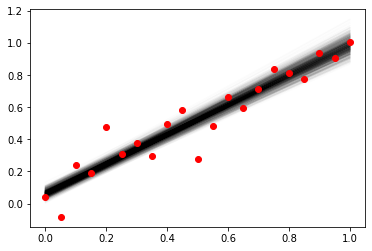

In [581]:
std_s = torch.exp(0.5*logvar_slope)
std_i = torch.exp(0.5*logvar_intercept)

for i in range(1000):
    w_i = mu_intercept + std_i*torch.randn(1)
    w_s = mu_slope + std_s*torch.randn(1)
    Yhat = (w_i + w_s*X).detach().numpy()
    plt.plot(X,Yhat,'k-',alpha=0.01)

plt.plot(X,Y,'ro')

Thus, we have a mechanism for fitting one distribution (which we get to pick) to another (even when we can't evaluate it).  In Gal and Ghahramani, they show that dropout is equivalent performing variational inference with a particular form of $q$ to $P(\omega|\mathbf{X},\mathbf{Y})$.  We'll return to that soon, but first, we need to talk about the Gaussian Process.

## 5. Gaussian process regression
A multivariate normal (or Gaussian) distribution models random vectors of length $n$, especially when the entries of those vectors vary together (which is to say that they have *covariance*).  It's not the only way to model such a situation (there are lots of probability distributions after all), but its the simplest and it has nice properties.  One of these nice properties is that we only have to have access to two things in order to fully characterize its behavior: a mean vector $\mu \in \mathbb{R}^n$ and a covariance matrix $K \in \mathbb{R}^{n\times n}$. 

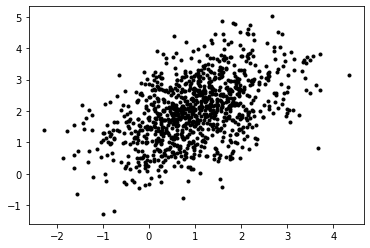

In [33]:
import matplotlib.pyplot as plt
mu = np.array([1,2])
K = np.array([[1.0,0.5],[0.5,1]])

# A simple way to draw random samples from a multivariate
# normal distribution is by taking a Cholesky decomposition
# of the covariance matrix, and multiplying it 
# by noise from a standard Gaussian of size n
L = np.linalg.cholesky(K)
y = mu + np.random.randn(1000,2)@L.T

plt.plot(y[:,0],y[:,1],'k.')


### 5a. Kernels
This is written $P(\mathbf{y}) = \mathcal{N}(\mathbf{y};\mu,K)$.  This construct lets us make a prediction for $\mathbf{y}$ and also evaluate its uncertainty.  Fine, but in machine learning, we're typically interested in making predictions based on some *features*, which we'll call $\mathbf{x}$.  Let's think about $\mathbf{x}$ as, say, a single coordinate in space (although such a feature could be anything).  For our predictive scheme to be sane, it stands to reason that when we make predictions based on these features, if the features are similar, the prediction ought to be similar, and when they are different, the output ought to be different.  To that end, we can introduce a special function $K(\mathbf{x}_1,\mathbf{x}_2)$ that takes as an input two features, and outputs their *covariance*.  This function, which measures how related two predictions ought to be based on features, is called a *kernel*, and there are many possible choices.  

For many applications, such kernels can be written as $K(\|\mathbf{x}_1 - \mathbf{x}_2\|)$, which means that the covariance between two predictions is just a function of the distance between the associated features.  One popular kernel that behaves this way is called the squared exponential kernel.
$$ K(\mathbf{x}_1,\mathbf{x}_2) = \sigma^2 \mathrm{exp} -\left(\frac{\|\mathbf{x}_1 - \mathbf{x}_2\|}{l}\right)^2,$$ where $\sigma^2$ is the scale of the variance and $l$ is the so-called length scale, how quickly predictions become uncorrelated as features become different. 

It's helpful to run the following cell a few times with different spacings between $x_1$ and $x_2$, and watch the degree of correlation between the resulting $y$ values change.

Text(0, 0.5, 'y2')

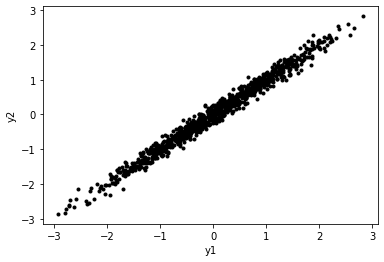

In [584]:
def squared_exponential(x1,x2,sigma2=1,l=0.1):
    return sigma2*np.exp(-((x1 - x2)/l)**2)

x1 = 0.5
x2 = 0.51

K_11 = squared_exponential(x1,x1)
K_12 = squared_exponential(x1,x2)
K_22 = squared_exponential(x2,x2)

K = np.zeros((2,2))
K[0,0] = K_11
K[0,1] = K_12
K[1,0] = K_12
K[1,1] = K_22

L = np.linalg.cholesky(K)

y = np.random.randn(1000,2)@L.T
plt.plot(y[:,0],y[:,1],'k.')
plt.xlabel('y1')
plt.ylabel('y2')

Of course, as the features get further apart, predictions become less correlated.

### 5b. A distribution over functions
Now, let's say that we have 100 feature values, and we want to make predictions for all of them.  What do the resulting predictions look like?  We can draw random samples from the normal distribution with zero mean and covariance matrix given by all pairwise kernel evaluations.  
$$ P(\mathbf{y}|\mathbf{x}) = \mathcal{N}(\mathbf{y};\mathbf{0},\mathbf{K}(\mathbf{x},\mathbf{x}')) $$
and plot the $\mathbf{y}$ values as a function of $\mathbf{x}$.

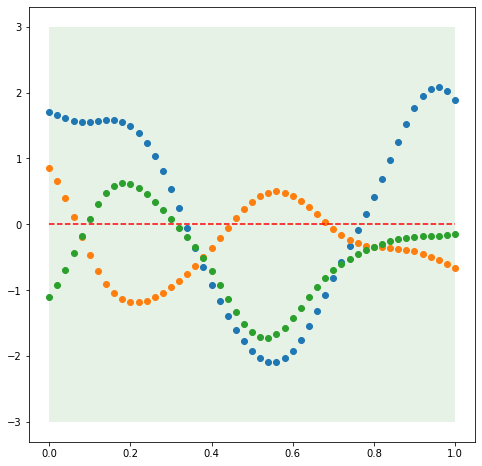

In [595]:
from sklearn.metrics import pairwise_distances

# Number of places to evaluate
n_points = 51

# Pointwise feature values, in this case evenly space between 0 and 1 (although
# this is just for simplicity: ordering doesn't matter at all here!)
x = np.linspace(0,1,n_points)

# Compute the kernel values, which involve computing pairwise distances
sigma2 = 1
l = 0.2
D = pairwise_distances(x.reshape(-1,1),x.reshape(-1,1))
K = sigma2*np.exp(-np.abs(D/l)**2) + 1e-10*np.eye(n_points) 
#The second term above is to ensure that K isn't singular

# Draw 3 random samples from the 51d probability distribution
L = np.linalg.cholesky(K)
y = L@np.random.randn(n_points,3)

# Plot each sample as a function of the feature
plt.plot(x,y,'o')

# Plot the mean and 3-sigma envelope of the distribution
mu = np.zeros_like(x)
std = np.sqrt(np.diag(K))
plt.plot(x,mu,'r--')
plt.fill_between(x,mu-3*std,mu+3*std,alpha=0.1,facecolor='g')
plt.gcf().set_size_inches(8,8)


This multivariate normal produces predictions that are similar in regions of feature space that are close together.  Perhaps it's also clear that the number of points where we evaluate this doesn't really matter (try changing N_points above).  Indeed, abstractly, we could evaluate this at every location in the real-valued feature space, of which there are infinitely many.  The resulting object is a *prior probability distribution over functions*, where any two points are jointly Gaussian.  This distribution over functions is called a Gaussian process.

### 5c. Conditioning on training data
Why is this useful?  The Gaussian process is an infinite-dimensional multivariate Gaussian.  The nice property of Gaussians is that when a value is observed somewhere, it is very easy to condition the rest of the variables on that value: there's an analytical solution.  Let's imagine that we actually observe the values of $X$ and $Y $ at a few places (call these the training set).  Then we can evaluate the predictive distribution over $y^*$ at some new location in feature space $\mathbf{x}^*$ in closed form:

$$
P(y^*|\mathbf{x}^*,\mathbf{X},\mathbf{Y}) = \mathcal{N}(y^*;\mu,\Sigma) 
$$
$$
\mu = K(\mathbf{x}^*,\mathbf{X}) (K(\mathbf{X},\mathbf{X}) + \tau^{-1} I)^{-1} \mathbf{Y} $$
$$
\Sigma = K(\mathbf{x}^*,\mathbf{x}^*) - K(\mathbf{x}^*,\mathbf{X})(K(\mathbf{X},\mathbf{X}) + \tau^{-1}I)^{-1}K(\mathbf{X},\mathbf{x}^*),
$$
where $\tau$ is the observational precision (the reciprocal of the observational variance).  

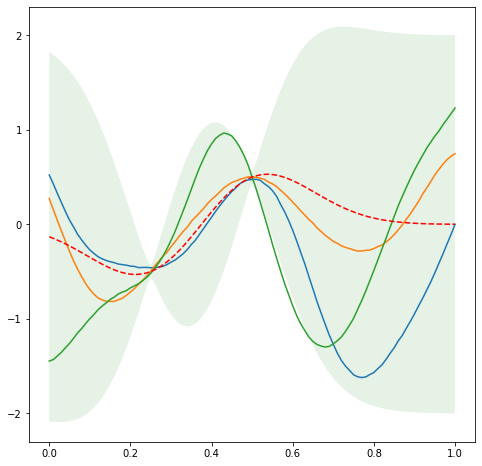

In [596]:
n_points = 101

# Test points
x = np.linspace(0,1,n_points)

# Training points
X = np.array([0.25,0.5])
Y = np.array([-0.5,0.5])

sigma2 = 1
l = 0.2

tau = 1000.

Dxx = pairwise_distances(x.reshape(-1,1),x.reshape(-1,1))
DxX = pairwise_distances(x.reshape(-1,1),X.reshape(-1,1))
DXX = pairwise_distances(X.reshape(-1,1),X.reshape(-1,1))

Kxx = sigma2*np.exp(-(Dxx/l)**2) + 1e-5*np.eye(n_points)
KxX = sigma2*np.exp(-(DxX/l)**2)
KXX = sigma2*np.exp(-(DXX/l)**2)

mu = KxX @ np.linalg.inv(KXX + 1./tau*np.eye(KXX.shape[0])) @ Y
Sigma = Kxx - KxX @  np.linalg.inv(KXX + 1./tau*np.eye(KXX.shape[0])) @ KxX.T

L = np.linalg.cholesky(Sigma)
y = mu + np.random.randn(3,n_points) @ L.T
plt.plot(x,y.T)


std = np.sqrt(np.diag(Sigma))
plt.plot(x,mu,'r--')
plt.fill_between(x,mu-2*std,mu+2*std,alpha=0.1,facecolor='g')
plt.gcf().set_size_inches(8,8)

### 5d. Neural network as a kernel?
Conditioned on the form of the kernel, the Gaussian process provides a consistent way for making predictions based on training examples along with uncertainty estimates.  However, it's often the case for complicated data that a simple, stationary kernel like the radial basis function is too restrictive, and thus a more expressive kernel is needed.

One such kernel is given by something that looks rather like a neural network:
$$
K(\mathbf{x}_1,\mathbf{x}_2) = \int \sigma(\mathbf{w}^T \mathbf{x}_1 + b) \sigma(\mathbf{w}^T \mathbf{x}_2 + b) P(\mathbf{w}) P(\mathbf{b}), $$
with $\sigma(\cdot)$ an activation function (frequently Tanh or ReLU), and $P(\mathbf{w})$ and $P(\mathbf{b})$ prior distributions over the weights and biases.  While the integral is intractable, we can approximate it, once again, with Monte Carlo integration, i.e. by drawing $K$ independent samples $\mathbf{w}_k \sim P(\mathbf{w})$ and $\mathbf{b}_k \sim P(\mathbf{w})$ and evaluating
$$
K(\mathbf{x}_1,\mathbf{x}_2) = \int \sigma(\mathbf{w}^T \mathbf{x}_1 + b) \sigma(\mathbf{w}^T \mathbf{x}_2 + b) P(\mathbf{w}) P(\mathbf{b}) \approx \sum_{k=1}^K \sigma(\mathbf{w}_k^T \mathbf{x}_1 + b_k) \sigma(\mathbf{w}_k^T \mathbf{x}_2 + b_k).
$$
Resulting samples from the Gaussian process with this kernel end up looking something like the following.

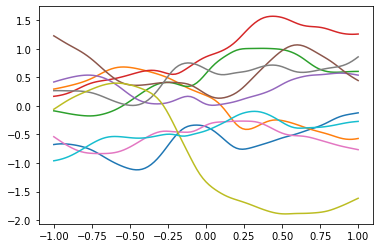

In [649]:
m = 101
k = 1000
x = np.linspace(-1,1,m)

X = np.array([-0.5,0,0.5])
Y = np.array([0.0,0.1,0.0])

tau = 100
W = np.random.randn(2,k)*5

def relu(z):
    return np.maximum(z,np.zeros_like(z))

def deep_kernel(x,y):
    xhat = np.vander(x,N=2)
    yhat = np.vander(y,N=2)
    z1 = np.tanh(xhat@W)
    z2 = np.tanh(yhat@W)
    return 1./k*z1@z2.T

Kstarstar = deep_kernel(x,x) + 1e-10*np.eye(m)
plt.figure()
L = np.linalg.cholesky(Kstarstar)
for i in range(10):
    plt.plot(x, L @ np.random.randn(m))

These functions are, as expected, quite general.  As before, we can condition the function on some training data when available:

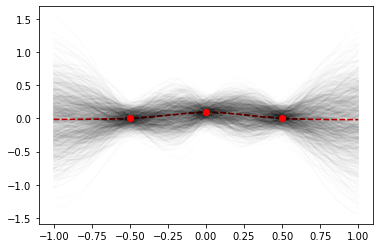

In [657]:
plt.figure()
    
K = deep_kernel(X,X) + 1e-10*np.eye(X.shape[0])
Kstar = deep_kernel(x,X)
mu = Kstar @ np.linalg.inv(K + 1./tau*np.eye(len(X))) @ Y
Sigma = Kstarstar - Kstar @  np.linalg.inv(K + 1./tau*np.eye(len(X))) @ Kstar.T

L = np.linalg.cholesky(Sigma)
samples = mu + (L@np.random.randn(m,1000)).T

plt.plot(x,mu,'r--')
plt.plot(x,samples.T,'k-',alpha=0.01)
#plt.fill_between(x,mu-6*np.diag(Sigma),mu+6*np.diag(Sigma),alpha=0.1)
plt.plot(X,Y,'ro')

### 5e. Neural net as a Gaussian process!?
Now things get a little bit strange.  Having assumed the kernel above, Gal and Ghahramani go on to show that the prior distribution over functions that is produced by the kernel described above is *exactly the same* as the distribution over functions produced by a neural network with a single hidden layer with independent and normally distributed weights and biases.  To see that this is the case, we can draw some random weights and biases, and plot them:



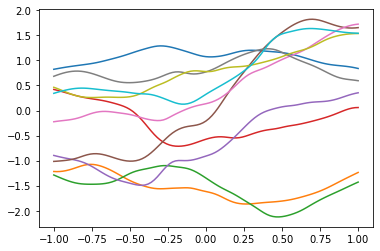

In [659]:
for i in range(10):
    W1 = 5*np.random.randn(2,k)
    W2 = np.random.randn(k,1)
    plt.plot(x,np.squeeze(np.sqrt(1./k)*np.tanh(np.vander(x,N=2)@W1)@W2))

While the analysis is informal, we can clearly see that these are samples from the same distribution as the ones we drew using the Gaussian Process: again a neural network with random weights is equivalent to a Gaussian process with the particular kernel described above.  

### 5f. An aside
This equivalence suggests a way to get Bayesian uncertainty bounds using neural networks: interpret them as Gaussian Processes and condition on the training data as one does for GPs, with the analytical solution given in 5c!  This is actually a strange idea in that it seems also to suggest that one could "train" a neural net without having to do any actual training (in the sense of gradient descent).  Conditioning a neural network GP this way is equivalent to comparing all possible neural nets to the data, and retaining the ones that are consistent with both the training data and the prior over weights.    

## 6. Putting the pieces together
Unfortunately, Gaussian Processes are not practical for large amounts of data, because of the necessity of writing down and inverting the covariance matrix between all of the training data.  Furthermore, the marginalization that we performed for the GP becomes more difficult as the dimensionality of the feature set grows larger.  Because exact Bayesian inference is intractable, Gal and Ghahramani suggest the use of the aforementioned Variational Inference as a means to approximate the posterior distribution over the weights.  While in the above description of VI for linear regression, we used a normal distribution over the weight and bias, in this work they use a somewhat more exotic approximating distribution 
$$
q(W_i) = M_i \mathrm{diag}( \mathbf{z}_i)
$$
$$
z_{i,j} \sim \mathrm{Bernoulli}(p_i),
$$
which is to say that the variational distribution is the distribution over an underlying matrix of the same size as the weights, but with columns randomly set to zero.  They do also use a normal distribution (similar to above) to approximate $\mathbf{b}$.  

After a few more approximative tricks (a limit argument for a mixture of Gaussians, single sample Monte Carlo integration, etc.  Look in the appendix of the paper if you're curious), the authors end up finding the variational free energy that must be minimized with respect to underlying (non-dropped-out) weight matrices $M_.$ and bias $\mathbf{m}$ to be 
$$
\mathcal{L}_{GP-MC} = \frac{1}{N}\sum_{n=1}^N-\frac{\log P(y_n|x_n,\hat{\omega}_n)}{\tau} + \sum_{i=1}^L \lambda_i(p_i \|M_i\|^2_2 + \|\mathbf{m}_i\|^2_2),  
$$
and for which $\hat{\omega}_n$ is a sample from the variational distribution (i.e. an instance of MC-dropout).  The final, most critical point of the paper: this is exactly the same objective function as the one used for training a neural network with dropout(!).  The resulting matrices $\mathbf{W}_i$ computed using dropout are samples from $q(\omega)$ and are thus, by design, approximate samples from $P(\omega|\mathbf{X},\mathbf{Y})$.  Furthermore, the posterior predictive distribution generated by using these samples can be easily sampled from by drawing a sample from $q(\omega)$ and then running the neural network forward using this value: to wit, exactly what MC dropout was already doing.

With a sufficient number of samples in hand, one can easily compute things like credibility intervals, or any other statistic that can be derived from samples of the posterior predictive distribution.  This is not to say that the result is exact: many approximations were made in deriving the result which may lead to the result being substantially different from a less-approximative application of Bayesian inference (which may yet be a long way from reality due to model misspecification).  However, there is great value in having an understanding of which assumptions were made in the generation of a result, and this paper goes a long way in cultivating that understanding for an uncertainty quantification practice that is increasing in use.  

